## Dyna : Integrated Learning, Planning and Reacting

3 steps. Q-Learning, Model Update, N-step imagination

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, jdc, shutil
from tqdm import tqdm

from rl_glue import RLGlue
from agent import BaseAgent
from maze_env import ShortcutMazeEnvironment

os.makedirs('results', exist_ok=True)

In [59]:
class DynaQAgent(BaseAgent):

    def agent_init(self, agent_info):
        
        try:
            self.num_states = agent_info["num_states"]
            self.num_actions = agent_info["num_actions"]
        except:
            print("You need to pass num_states and num_actions")
        
        self.gamma = agent_info.get("discount", 0.95)
        self.step_size = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.1)
        self.planning_steps = agent_info.get("planning_steps", 10)

        self.rand_generator = np.random.RandomState(agent_info.get('random_seed', 42))
        self.planning_rand_generator = np.random.RandomState(agent_info.get('planning_random_seed', 42))

        #world model
        #dictionaries of dictionaries {state: {actions : {reward, next_state}}}
        self.q_values = np.zeros((self.num_states, self.num_actions))
        self.actions = list(range(self.num_actions))
        self.past_action = -1
        self.past_state = -1
        self.model = {}

    def agent_start(self, state):
        action = self.choose_action_egreedy(state)
        self.past_state = state
        self.past_action = action

        return self.past_action

    def agent_step(self, reward, state):
        self.q_values[self.past_state][self.past_action] += self.step_size*(reward + self.gamma*(np.max(self.q_values[state])) - self.q_values[self.past_state][self.past_action])

        self.update_model(self.past_state, self.past_action, state, reward)
        self.planning_step()

        action = self.choose_action_egreedy(state)
        self.past_state = state
        self.past_action = action
        return self.past_action

    def agent_end(self,reward):
        self.q_values[self.past_state][self.past_action] += self.step_size*(reward - self.q_values[self.past_state][self.past_action])

        self.update_model(self.past_state, self.past_action, -1, reward)
        self.planning_step()

    def update_model(self, past_state, past_action, state, reward):
        """updates the model 
        
        Args:
            past_state       (int): s
            past_action      (int): a
            state            (int): s'
            reward           (int): r
        Returns:
            Nothing
        """
        # Update the model with the (s,a,s',r) tuple

        if past_state not in self.model:
            self.model[past_state] = {}
        self.model[past_state][past_action] = (state,reward)

    def planning_step(self):
        """performs planning, i.e. indirect RL"""
        
        # The indirect RL step:
        # - Choose a state and action from the set of experiences that are stored in the model. (~2 lines)
        # - Query the model with this state-action pair for the predicted next state and reward.(~1 line)
        # - Update the action values with this simulated experience.                            (2~4 lines)
        # - Repeat for the required number of planning steps.
        

        for _ in range(self.planning_steps):
            chosen_state = self.planning_rand_generator.choice(list(self.model.keys()))
            chosen_action = self.planning_rand_generator.choice(list(self.model[chosen_state].keys()))
            next_st, rew = self.model[chosen_state][chosen_action]

            if next_st != -1:
                self.q_values[chosen_state][chosen_action]  += self.step_size *(rew + self.gamma* np.max(self.q_values[next_st])  - self.q_values[chosen_state][chosen_action])
            else:
                self.q_values[chosen_state][chosen_action]  += self.step_size *(rew - self.q_values[chosen_state][chosen_action])

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            rand_generator : agent's random generator to keep consistency and reproducibility
            q_values (Numpy array): the array of action values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []
        
        for i in range(len(q_values)):
        
            if q_values[i] > top:
                top = q_values[i]
                ties = []
            
            if q_values[i] == top:
                ties.append(i)
        
        return self.rand_generator.choice(ties)
    
    def choose_action_egreedy(self, state):
        """returns an action using an epsilon-greedy policy w.r.t. the current action-value function.

        Important: assume you have a random number generator 'rand_generator' as a part of the class
                    which you can use as self.rand_generator.choice() or self.rand_generator.rand()

        Args:
        rand_generator : agent's random generator to keep consistency and reproducibility
            state (List): coordinates of the agent (two elements)
        Returns:
            The action taken w.r.t. the aforementioned epsilon-greedy policy
        """
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.choice(self.actions)
        else:
            values = self.q_values[state]
            action = self.argmax(values)

        return action
    

In [22]:
def run_experiment(env, agent, env_parameters, agent_parameters, exp_parameters):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_episodes = exp_parameters['num_episodes']
    planning_steps_all = agent_parameters['planning_steps']

    env_info = env_parameters                     
    agent_info = {"num_states" : agent_parameters["num_states"],  # We pass the agent the information it needs. 
                  "num_actions" : agent_parameters["num_actions"],
                  "epsilon": agent_parameters["epsilon"], 
                  "discount": env_parameters["discount"],
                  "step_size" : agent_parameters["step_size"]}

    all_averages = np.zeros((len(planning_steps_all), num_runs, num_episodes)) # for collecting metrics 
    log_data = {'planning_steps_all' : planning_steps_all}                     # that shall be plotted later

    for idx, planning_steps in enumerate(planning_steps_all):

        print('Planning steps : ', planning_steps)
        os.system('sleep 0.5')                    # to prevent tqdm printing out-of-order before the above print()
        agent_info["planning_steps"] = planning_steps  

        for i in tqdm(range(num_runs)):

            agent_info['random_seed'] = i
            agent_info['planning_random_seed'] = i

            rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
            rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment

            for j in range(num_episodes):

                rl_glue.rl_start()                # We start an episode. Here we aren't using rl_glue.rl_episode()
                                                  # like the other assessments because we'll be requiring some 
                is_terminal = False               # data from within the episodes in some of the experiments here 
                num_steps = 0
                while not is_terminal:
                    reward, _, action, is_terminal = rl_glue.rl_step()  # The environment and agent take a step 
                    num_steps += 1                                      # and return the reward and action taken.

                all_averages[idx][i][j] = num_steps

    log_data['all_averages'] = all_averages
    np.save("results/Dyna-Q_planning_steps", log_data)
    

def plot_steps_per_episode(file_path):
    '''Needs a .npy file of dimension (#ablations, num_runs, num_episodes) 
    where each entry is the number of steps for that particular episode'''
    
    data = np.load(file_path,allow_pickle=True).item()
    all_averages = data['all_averages']
    planning_steps_all = data['planning_steps_all']

    for i, planning_steps in enumerate(planning_steps_all):
        plt.plot(np.mean(all_averages[i], axis=0), label='Planning steps = '+str(planning_steps))

    plt.legend(loc='upper right')
    plt.xlabel('Episodes')
    plt.ylabel('Steps\nper\nepisode', rotation=0, labelpad=40)
    plt.axhline(y=16, linestyle='--', color='grey', alpha=0.4)
    plt.show()

Planning steps :  0


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


Planning steps :  5


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


Planning steps :  50


100%|██████████| 30/30 [01:44<00:00,  3.48s/it]


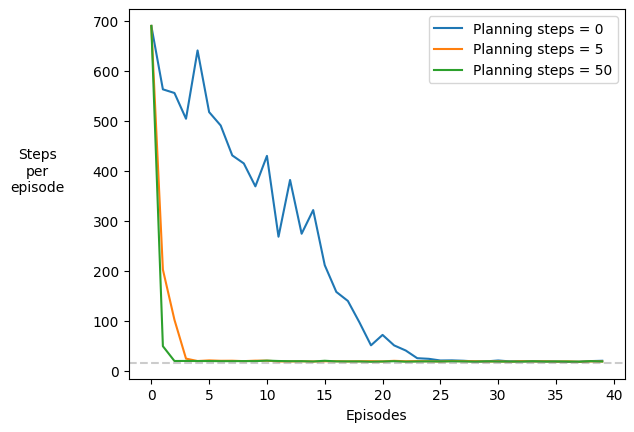

'/home/ayhaos/Daily Research Progress/night/jour-env/model-based-rl/results.zip'

In [23]:
# Experiment parameters
experiment_parameters = {
    "num_runs" : 30,                     # The number of times we run the experiment
    "num_episodes" : 40,                 # The number of episodes per experiment
}

# Environment parameters
environment_parameters = { 
    "discount": 0.95,
}

# Agent parameters
agent_parameters = {  
    "num_states" : 54,
    "num_actions" : 4, 
    "epsilon": 0.1, 
    "step_size" : 0.125,
    "planning_steps" : [0, 5, 50]       # The list of planning_steps we want to try
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQAgent              # The agent

run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_steps_per_episode('results/Dyna-Q_planning_steps.npy')   
shutil.make_archive('results', 'zip', 'results')

In [26]:
def run_experiment_with_state_visitations(env, agent, env_parameters, agent_parameters, exp_parameters, result_file_name):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_max_steps = exp_parameters['num_max_steps']
    planning_steps_all = agent_parameters['planning_steps']

    env_info = {"change_at_n" : env_parameters["change_at_n"]}                     
    agent_info = {"num_states" : agent_parameters["num_states"],  
                  "num_actions" : agent_parameters["num_actions"],
                  "epsilon": agent_parameters["epsilon"], 
                  "discount": env_parameters["discount"],
                  "step_size" : agent_parameters["step_size"]}

    state_visits_before_change = np.zeros((len(planning_steps_all), num_runs, 54))  # For saving the number of
    state_visits_after_change = np.zeros((len(planning_steps_all), num_runs, 54))   #     state-visitations 
    cum_reward_all = np.zeros((len(planning_steps_all), num_runs, num_max_steps))   # For saving the cumulative reward
    log_data = {'planning_steps_all' : planning_steps_all}

    for idx, planning_steps in enumerate(planning_steps_all):

        print('Planning steps : ', planning_steps)
        os.system('sleep 1')          # to prevent tqdm printing out-of-order before the above print()
        agent_info["planning_steps"] = planning_steps  # We pass the agent the information it needs. 

        for run in tqdm(range(num_runs)):

            agent_info['random_seed'] = run
            agent_info['planning_random_seed'] = run

            rl_glue = RLGlue(env, agent)  # Creates a new RLGlue experiment with the env and agent we chose above
            rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment

            num_steps = 0
            cum_reward = 0

            while num_steps < num_max_steps-1 :

                state, _ = rl_glue.rl_start()  # We start the experiment. We'll be collecting the 
                is_terminal = False            # state-visitation counts to visiualize the learned policy
                if num_steps < env_parameters["change_at_n"]: 
                    state_visits_before_change[idx][run][state] += 1
                else:
                    state_visits_after_change[idx][run][state] += 1

                while not is_terminal and num_steps < num_max_steps-1 :
                    reward, state, action, is_terminal = rl_glue.rl_step()  
                    num_steps += 1
                    cum_reward += reward
                    cum_reward_all[idx][run][num_steps] = cum_reward
                    if num_steps < env_parameters["change_at_n"]:
                        state_visits_before_change[idx][run][state] += 1
                    else:
                        state_visits_after_change[idx][run][state] += 1

    log_data['state_visits_before'] = state_visits_before_change
    log_data['state_visits_after'] = state_visits_after_change
    log_data['cum_reward_all'] = cum_reward_all
    np.save("results/" + result_file_name, log_data)

def plot_cumulative_reward(file_path, item_key, y_key, y_axis_label, legend_prefix, title):

    data_all = np.load(file_path,allow_pickle=True).item()
    data_y_all = data_all[y_key]
    items = data_all[item_key]

    for i, item in enumerate(items):
        plt.plot(np.mean(data_y_all[i], axis=0), label=legend_prefix+str(item))

    plt.axvline(x=3000, linestyle='--', color='grey', alpha=0.4)
    plt.xlabel('Timesteps')
    plt.ylabel(y_axis_label, rotation=0, labelpad=60)
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

Planning steps :  5


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


Planning steps :  10


100%|██████████| 10/10 [00:30<00:00,  3.08s/it]


Planning steps :  50


100%|██████████| 10/10 [02:25<00:00, 14.54s/it]


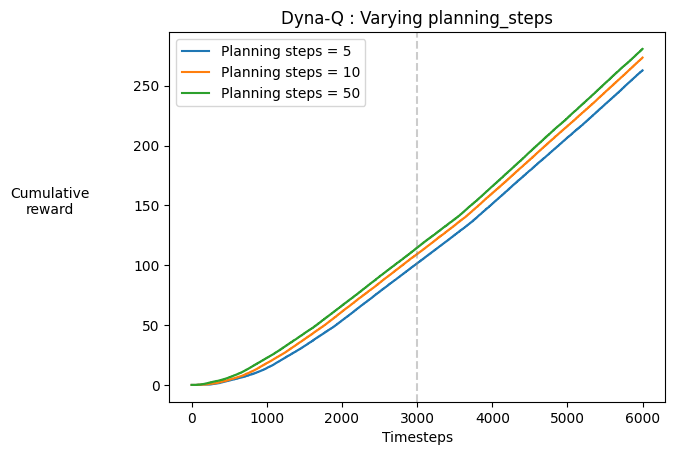

In [27]:
experiment_parameters = {
    "num_runs" : 10,                     # The number of times we run the experiment
    "num_max_steps" : 6000,              # The number of steps per experiment
}

# Environment parameters
environment_parameters = { 
    "discount": 0.95,
    "change_at_n": 3000
}

# Agent parameters
agent_parameters = {  
    "num_states" : 54,
    "num_actions" : 4, 
    "epsilon": 0.1, 
    "step_size" : 0.125,
    "planning_steps" : [5, 10, 50]      # The list of planning_steps we want to try
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQAgent              # The agent

run_experiment_with_state_visitations(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters, "Dyna-Q_shortcut_steps")    
plot_cumulative_reward('results/Dyna-Q_shortcut_steps.npy', 'planning_steps_all', 'cum_reward_all', 'Cumulative\nreward', 'Planning steps = ', 'Dyna-Q : Varying planning_steps')

In [30]:
def plot_state_visitations(file_path, plot_titles, idx):

    data = np.load(file_path, allow_pickle=True).item()
    data_keys = ["state_visits_before", "state_visits_after"]
    positions = [211,212]
    titles = plot_titles
    wall_ends = [None,-1]

    for i in range(2):

        state_visits = data[data_keys[i]][idx]
        average_state_visits = np.mean(state_visits, axis=0)
        grid_state_visits = np.rot90(average_state_visits.reshape((6,9)).T)
        grid_state_visits[2,1:wall_ends[i]] = np.nan # walls
        #print(average_state_visits.reshape((6,9)))
        plt.subplot(positions[i])
        plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=1, cmap='viridis')
        plt.text(3+0.5, 0+0.5, 'S', horizontalalignment='center', verticalalignment='center')
        plt.text(8+0.5, 5+0.5, 'G', horizontalalignment='center', verticalalignment='center')
        plt.title(titles[i])
        plt.axis('off')
        cm = plt.get_cmap()
        cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([1., 0.0, 0.075, 1.])
    cbar = plt.colorbar(cax=cax)
    plt.show()


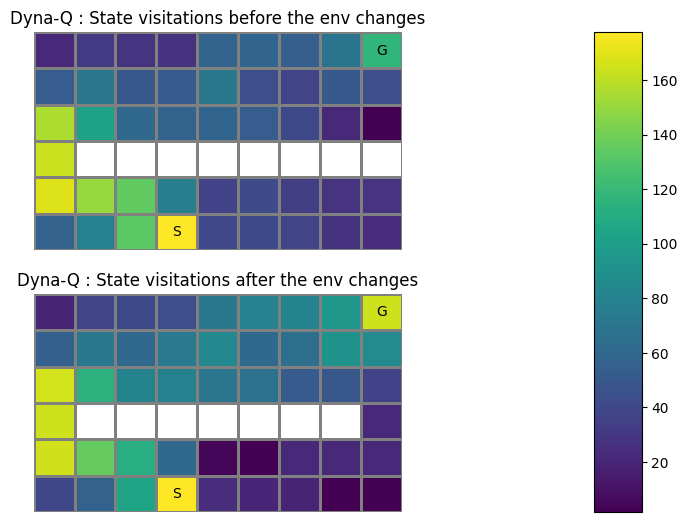

In [31]:
plot_state_visitations("results/Dyna-Q_shortcut_steps.npy", ['Dyna-Q : State visitations before the env changes', 'Dyna-Q : State visitations after the env changes'], 1)

As evident ; DynaQ isn't robust to environemnt changes - even after opening a shortcut ; it fails to find it through exploration abd continues to stick to the previously found soln.

We thus try to incentivize exploration through spiking rewards of state,actions not visited in a long time 

## Dyna-Q+ 

Basic intuition that we start incentivizing the actions that haven't been taken since a long time.

r' = r + k*sqrt(time_elapsed)

1. actions jo pehle nhi hue the -- they weren't allowed in planning step. Now they would
2. the initial entry of such actions would be containing the tuple as (same_state,0) i.e. self loop but 0 reward

In [65]:
class DynaQPlusAgent(BaseAgent):

    def agent_init(self,agent_info):
        try:
            self.num_states = agent_info["num_states"]
            self.num_actions = agent_info["num_actions"]
        except:
            print("You need to pass both 'num_states' and 'num_actions' \
                   in agent_info to initialize the action-value table")
        self.gamma = agent_info.get("discount", 0.95)
        self.step_size = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.1)
        self.planning_steps = agent_info.get("planning_steps", 10)
        self.kappa = agent_info.get("kappa", 0.001)

        self.rand_generator = np.random.RandomState(agent_info.get('random_seed', 42))
        self.planning_rand_generator = np.random.RandomState(agent_info.get('planning_random_seed', 42))

        # Next, we initialize the attributes required by the agent, e.g., q_values, model, tau, etc.
        # The visitation-counts can be stored as a table as well, like the action values 
        self.q_values = np.zeros((self.num_states, self.num_actions))
        self.tau = np.zeros((self.num_states, self.num_actions))
        self.actions = list(range(self.num_actions))
        self.past_action = -1
        self.past_state = -1
        self.model = {}

    def update_model(self, past_state, past_action, state, reward):
        
        if past_state not in self.model:
            self.model[past_state] = {past_action : (state, reward)}
            for act in self.actions:
                if past_action != act:
                    self.model[past_state][act] = (past_state,0)
        else:
            self.model[past_state][past_action] = (state,reward)

    def planning_step(self):
        
        for _ in range(self.planning_steps):
            chosen_state = self.planning_rand_generator.choice(list(self.model.keys()))
            chosen_action = self.planning_rand_generator.choice(list(self.model[chosen_state].keys()))

            next_st, reward = self.model[chosen_state][chosen_action]
            reward += self.kappa * np.sqrt(self.tau[chosen_state][chosen_action])

            if next_st != -1:
                self.q_values[chosen_state][chosen_action] += self.step_size*(reward + self.gamma*np.max(self.q_values[next_st]) - self.q_values[chosen_state][chosen_action])
            else:
                self.q_values[chosen_state][chosen_action] += self.step_size*(reward  - self.q_values[chosen_state][chosen_action])

    def agent_start(self, state):
        action = self.choose_action_egreedy(state)

        self.past_state = state
        self.past_action = action
        return self.past_action
    
    def agent_step(self, reward, state):
        self.tau += 1
        self.tau[self.past_state][self.past_action] = 0

        self.q_values[self.past_state][self.past_action] += self.step_size*(reward + self.gamma*np.max(self.q_values[state]) - self.q_values[self.past_state][self.past_action])
        self.update_model(self.past_state,self.past_action,state,reward)
        self.planning_step()

        action = self.choose_action_egreedy(state)
        self.past_state = state
        self.past_action = action

        return self.past_action
    
    def agent_end(self, reward):

        self.tau + 1
        self.tau[self.past_state][self.past_action] = 0

        self.q_values[self.past_state][self.past_action] += self.step_size*(reward - self.q_values[self.past_state][self.past_action])
        self.update_model(self.past_state, self.past_action, -1, reward)
        self.planning_step()

    def argmax(self, q_values):
        
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

    def choose_action_egreedy(self, state):

        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.choice(self.actions)
        else:
            values = self.q_values[state]
            action = self.argmax(values)

        return action
        

In [70]:
experiment_parameters = {
    "num_runs" : 30,                     # The number of times we run the experiment
    "num_max_steps" : 6000,              # The number of steps per experiment
}

# Environment parameters
environment_parameters = { 
    "discount": 0.95,
    "change_at_n": 3000
}

# Agent parameters
agent_parameters = {  
    "num_states" : 54,
    "num_actions" : 4, 
    "epsilon": 0.1, 
    "step_size" : 0.5,
    "planning_steps" : [50]      
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQPlusAgent          # The agent

run_experiment_with_state_visitations(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters, "Dyna-Q+")
shutil.make_archive('results', 'zip', 'results')

Planning steps :  50


100%|██████████| 30/30 [09:17<00:00, 18.57s/it]


'/home/ayhaos/Daily Research Progress/night/jour-env/model-based-rl/results.zip'

In [75]:
def plot_cumulative_reward_comparison(file_name_dynaq, file_name_dynaqplus):

    cum_reward_q = np.load(file_name_dynaq, allow_pickle=True).item()['cum_reward_all'][2]
    cum_reward_qPlus = np.load(file_name_dynaqplus, allow_pickle=True).item()['cum_reward_all'][0]

    plt.plot(np.mean(cum_reward_qPlus, axis=0), label='Dyna-Q+')
    plt.plot(np.mean(cum_reward_q, axis=0), label='Dyna-Q')

    plt.axvline(x=3000, linestyle='--', color='grey', alpha=0.4)
    plt.xlabel('Timesteps')
    plt.ylabel('Cumulative\nreward', rotation=0, labelpad=60)
    plt.legend(loc='upper left')
    plt.title('Average performance of Dyna-Q and Dyna-Q+ agents in the Shortcut Maze\n')
    plt.show()

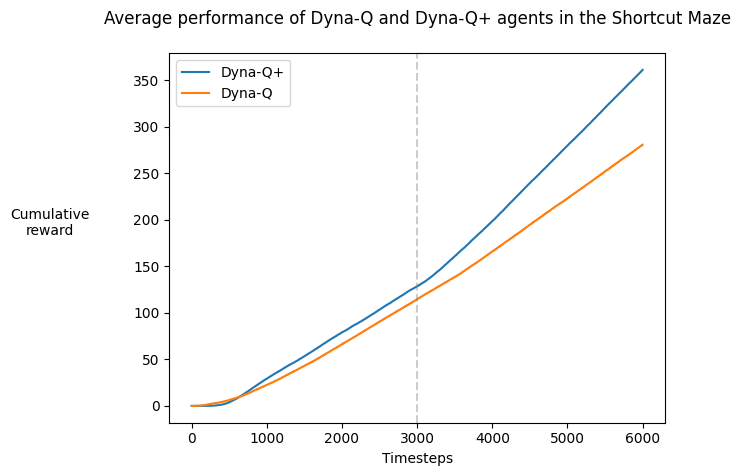

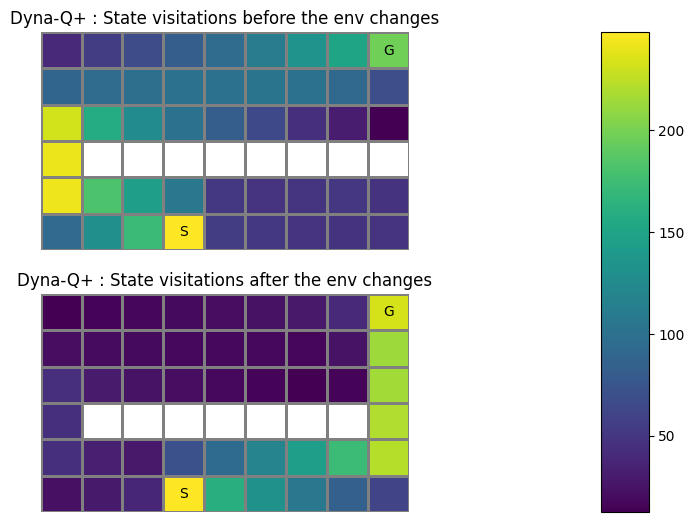

In [76]:
plot_cumulative_reward_comparison('results/Dyna-Q_shortcut_steps.npy', 'results/Dyna-Q+.npy')
plot_state_visitations("results/Dyna-Q+.npy", ['Dyna-Q+ : State visitations before the env changes', 'Dyna-Q+ : State visitations after the env changes'], 0)